In [2]:
import pandas as pd 
import os
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
import sklearn.gaussian_process as gp
import time
import pyts.approximation
import pickle
import gpflow
import tensorflow as tf
import csv
import sys

In [7]:
df = pd.read_csv ('uqvitalsignsdata/case01/uq_vsd_case01_trenddata.csv', error_bad_lines=False, index_col = False )

b'Skipping line 10: expected 55 fields, saw 56\nSkipping line 11: expected 55 fields, saw 56\nSkipping line 12: expected 55 fields, saw 56\nSkipping line 13: expected 55 fields, saw 56\nSkipping line 14: expected 55 fields, saw 56\nSkipping line 15: expected 55 fields, saw 56\nSkipping line 16: expected 55 fields, saw 56\nSkipping line 17: expected 55 fields, saw 56\nSkipping line 18: expected 55 fields, saw 56\nSkipping line 19: expected 55 fields, saw 56\nSkipping line 20: expected 55 fields, saw 56\nSkipping line 21: expected 55 fields, saw 56\nSkipping line 22: expected 55 fields, saw 57\nSkipping line 23: expected 55 fields, saw 57\nSkipping line 24: expected 55 fields, saw 57\nSkipping line 25: expected 55 fields, saw 57\nSkipping line 26: expected 55 fields, saw 57\nSkipping line 27: expected 55 fields, saw 57\nSkipping line 28: expected 55 fields, saw 57\nSkipping line 29: expected 55 fields, saw 57\nSkipping line 30: expected 55 fields, saw 57\nSkipping line 31: expected 55 fi

In [4]:
df = pd.read_csv("case01_clean.csv", index_col=False)
print(df)

              Time  RelativeTimeMilliseconds  Clock    HR  ST-II  Pulse  \
0     00:00:00_000                         0  17:33  55.0    NaN   55.0   
1     00:00:01_000                      1000  17:33  55.0    NaN   55.0   
2     00:00:02_000                      2000  17:33  55.0    NaN   54.0   
3     00:00:03_000                      3000  17:33  55.0    NaN   54.0   
4     00:00:04_000                      4000  17:33  55.0    NaN   49.0   
...            ...                       ...    ...   ...    ...    ...   
7291  02:01:31_000                   7291000  19:34   NaN    NaN   51.0   
7292  02:01:32_000                   7292000  19:34   NaN    NaN   51.0   
7293  02:01:33_000                   7293000  19:34   NaN    NaN   51.0   
7294  02:01:34_000                   7294000  19:34   NaN    NaN   51.0   
7295  02:01:35_000                   7295000  19:35   NaN    NaN   51.0   

       SpO2  Perf  etCO2  imCO2  ...  Tidal Volume Exp (Spiro)  \
0     100.0   0.4      0      0  

In [9]:
df.head()

,Time,RelativeTimeMilliseconds,Clock,HR,ST-II,Pulse,SpO2,Perf,etCO2,imCO2,...,Tidal Volume Exp (Spiro),Tidal Volume In (Spiro),Minute Volume Exp (Spiro),Minute Volume In (Spiro),Lung Compliance (Spiro),Airway Resistance (Spiro),Max Inspiratory Pressure (Spiro),Num Patient Alarms,Num Technical Alarms,Alarms...
0,00:00:00_000,0,17:33,55.0,NaN,55,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
1,00:00:01_000,1000,17:33,55.0,NaN,55,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
2,00:00:02_000,2000,17:33,55.0,NaN,54,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
3,00:00:03_000,3000,17:33,55.0,NaN,54,100,0.3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
4,00:00:04_000,4000,17:33,55.0,NaN,49,100,0.3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING


In [10]:
#replacing all empty values with NaN and then remove all NaN value columns
df_removed_allnan = df.copy()
nan_val = float("NaN")
df_removed_allnan.replace("",nan_val,inplace=True)
df_removed_allnan.dropna(how="all",axis=1, inplace =True)

In [11]:
df_removed_allnan

,Time,RelativeTimeMilliseconds,Clock,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,...,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR,Num Patient Alarms,Num Technical Alarms,Alarms...
0,00:00:00_000,0,17:33,55.0,55.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
1,00:00:01_000,1000,17:33,55.0,55.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
2,00:00:02_000,2000,17:33,55.0,54.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
3,00:00:03_000,3000,17:33,55.0,54.0,100.0,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
4,00:00:04_000,4000,17:33,55.0,49.0,100.0,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,02:01:31_000,7291000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7292,02:01:32_000,7292000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7293,02:01:33_000,7293000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7294,02:01:34_000,7294000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,5,5.0,7,0,1,ECG LEADS OFF


In [12]:
# getting the name of dropped columns from the main dataframe
df_cols = df.columns
cleaned_cols = df_removed_allnan.columns
list1 = df_cols.difference(cleaned_cols)
print(len(list1),'Columns dropped')
df_cols.difference(cleaned_cols)

28 Columns dropped


Index(['ART (Dia)', 'ART (Mean)', 'ART (Sys)', 'Airway Resistance (Spiro)',
       'BIS', 'EMG', 'Lung Compliance (Spiro)',
       'Max Inspiratory Pressure (Spiro)', 'Minute Volume Exp (Spiro)',
       'Minute Volume In (Spiro)', 'NBP (Pulse)', 'NBP (Time Remaining)',
       'SQI', 'ST-II', 'Set I:E Ratio', 'Set Mechanical Ventilation',
       'Set PAWmax', 'Set PAWmin', 'Set PEEP', 'Set RR', 'Set Tidal Volume',
       'Temp', 'Tidal Volume Exp (Spiro)', 'Tidal Volume In (Spiro)', 'etDES',
       'etISO', 'inDES', 'inISO'],
      dtype='object')

In [13]:
df_removed_allnan

,Time,RelativeTimeMilliseconds,Clock,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,...,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR,Num Patient Alarms,Num Technical Alarms,Alarms...
0,00:00:00_000,0,17:33,55.0,55.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
1,00:00:01_000,1000,17:33,55.0,55.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
2,00:00:02_000,2000,17:33,55.0,54.0,100.0,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
3,00:00:03_000,3000,17:33,55.0,54.0,100.0,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
4,00:00:04_000,4000,17:33,55.0,49.0,100.0,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,02:01:31_000,7291000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7292,02:01:32_000,7292000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7293,02:01:33_000,7293000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7294,02:01:34_000,7294000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,...,0.0,0.2,91,97,5,5.0,7,0,1,ECG LEADS OFF


In [14]:
df_removed_allnan.iloc[:,0:15]

,Time,RelativeTimeMilliseconds,Clock,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),NBP (Mean),etSEV,inSEV
0,00:00:00_000,0,17:33,55.0,55.0,100.0,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,00:00:01_000,1000,17:33,55.0,55.0,100.0,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,00:00:02_000,2000,17:33,55.0,54.0,100.0,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,00:00:03_000,3000,17:33,55.0,54.0,100.0,0.3,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,00:00:04_000,4000,17:33,55.0,49.0,100.0,0.3,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,02:01:31_000,7291000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05
7292,02:01:32_000,7292000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05
7293,02:01:33_000,7293000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05
7294,02:01:34_000,7294000,19:34,NaN,51.0,98.0,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05


In [15]:
df_removed_allnan.iloc[:,15:26]

,etN2O,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR,Num Patient Alarms,Num Technical Alarms,Alarms...
0,0.0,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
1,0.0,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
2,0.0,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
3,0.0,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
4,0.0,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
...,...,...,...,...,...,...,...,...,...,...,...
7291,0.0,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7292,0.0,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7293,0.0,0.0,0.2,91,97,744,5.4,7,0,1,ECG LEADS OFF
7294,0.0,0.0,0.2,91,97,5,5.0,7,0,1,ECG LEADS OFF


In [16]:
df_removed_allnan.isnull().sum()

Time                           0
RelativeTimeMilliseconds       0
Clock                          0
HR                            80
Pulse                          7
SpO2                           7
Perf                           7
etCO2                          0
imCO2                          0
awRR                          51
NBP (Sys)                     38
NBP (Dia)                    388
NBP (Mean)                   388
etSEV                        138
inSEV                        138
etN2O                          0
inN2O                          0
MAC                            0
etO2                           0
inO2                           0
Tidal Volume                   0
Minute Volume                  0
RR                             0
Num Patient Alarms             0
Num Technical Alarms           0
Alarms...                   6917
dtype: int64

['HR', 'Pulse', 'SpO2', 'Perf', 'etCO2', 'imCO2', 'awRR', 'NBP (Sys)', 'NBP (Dia)', 'NBP (Mean)', 'etSEV', 'inSEV', 'etN2O', 'inN2O', 'MAC', 'etO2', 'inO2', 'Tidal Volume', 'Minute Volume', 'RR', 'Num Patient Alarms', 'Num Technical Alarms']
HR


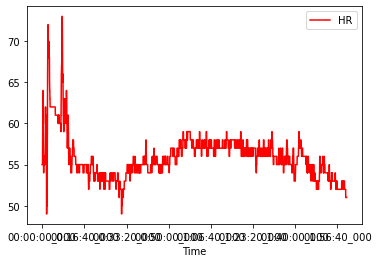

Pulse


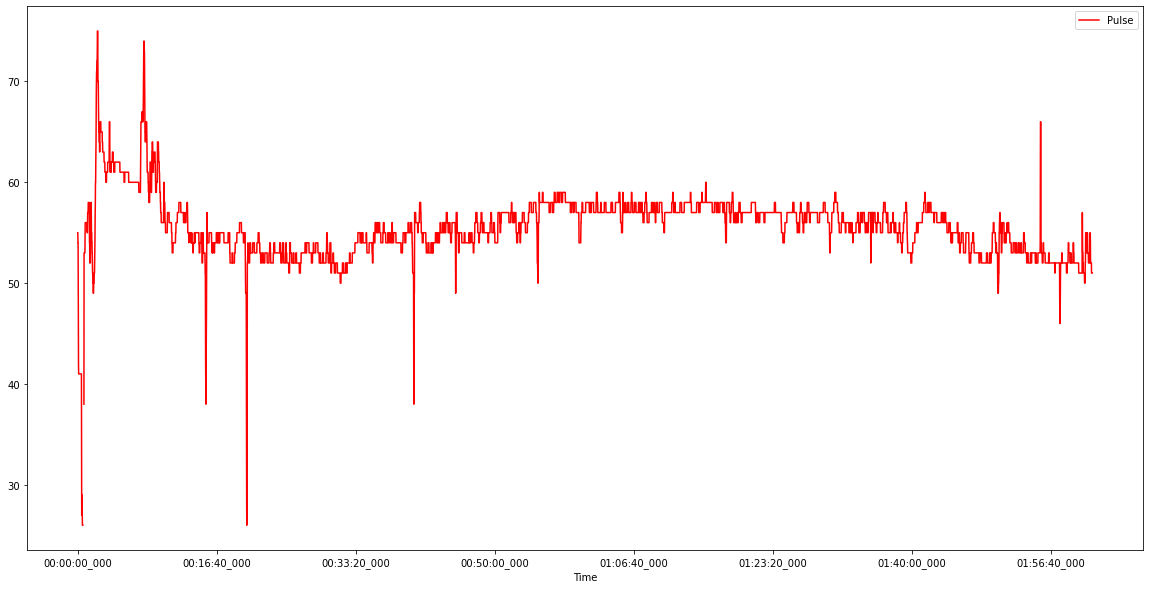

SpO2


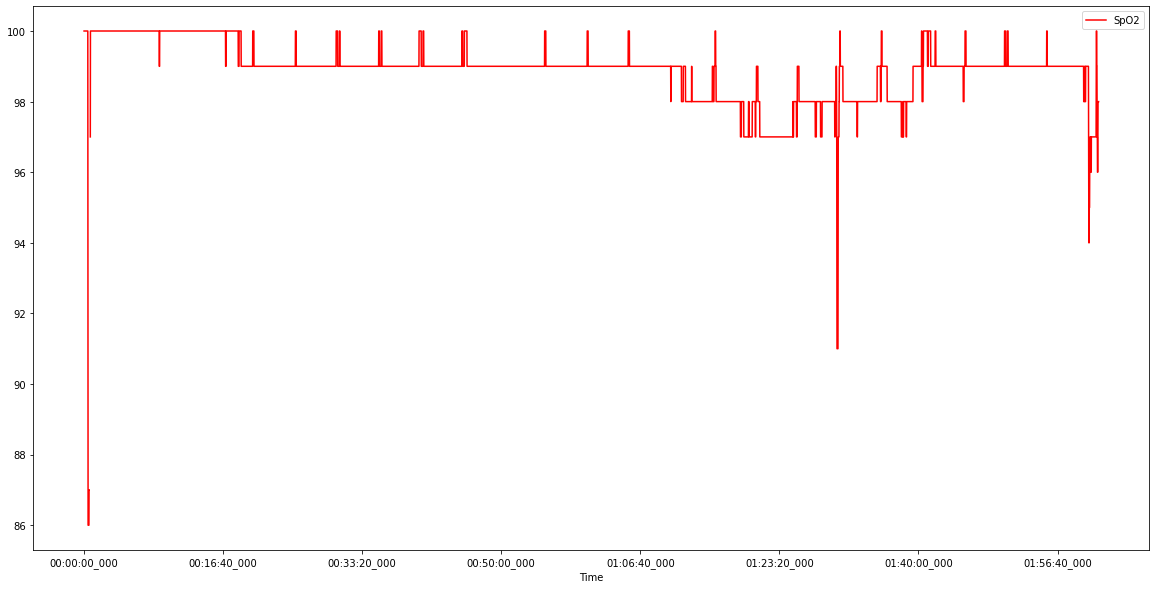

Perf


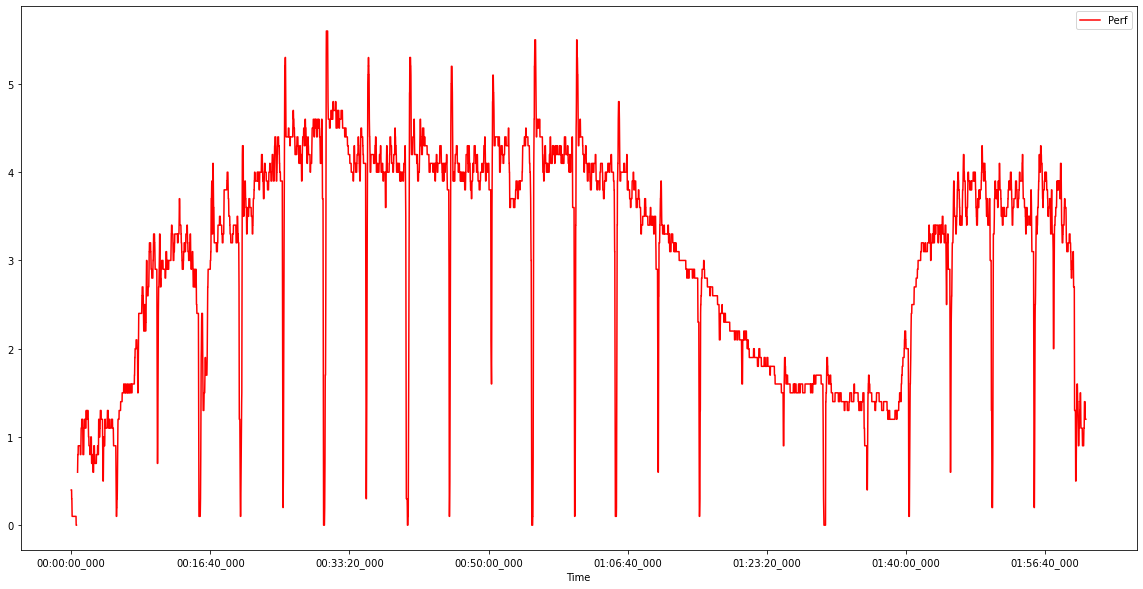

etCO2


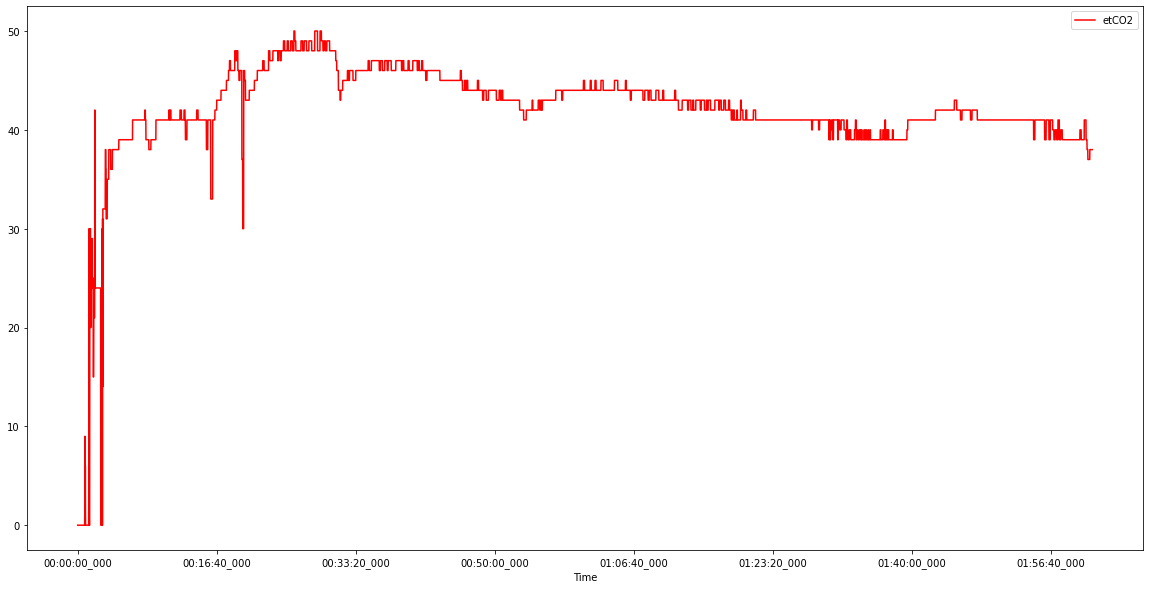

imCO2


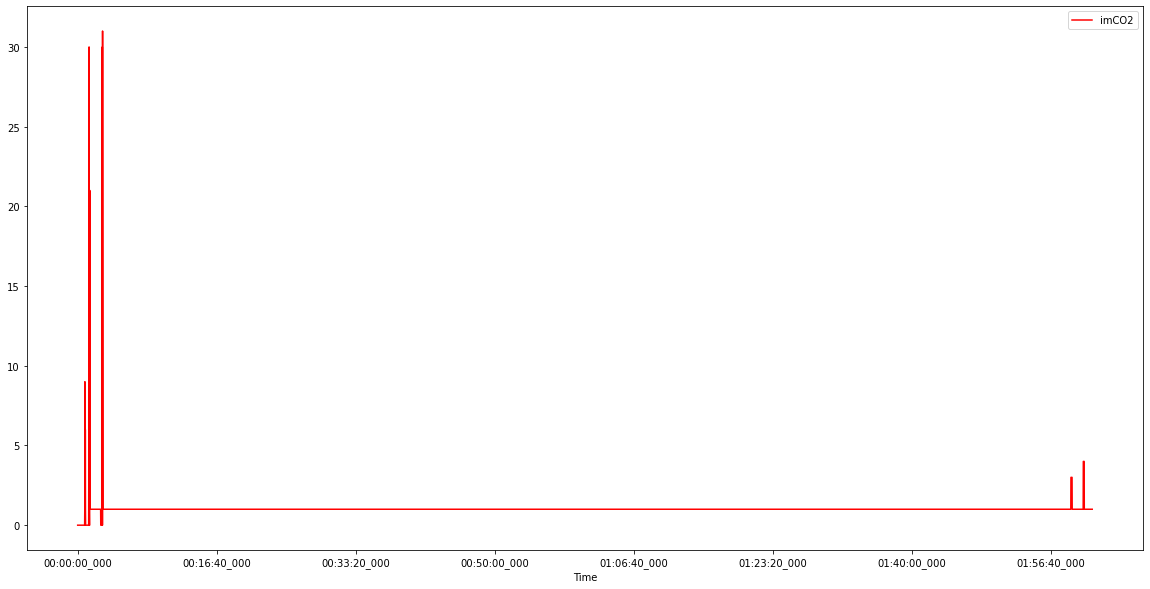

awRR


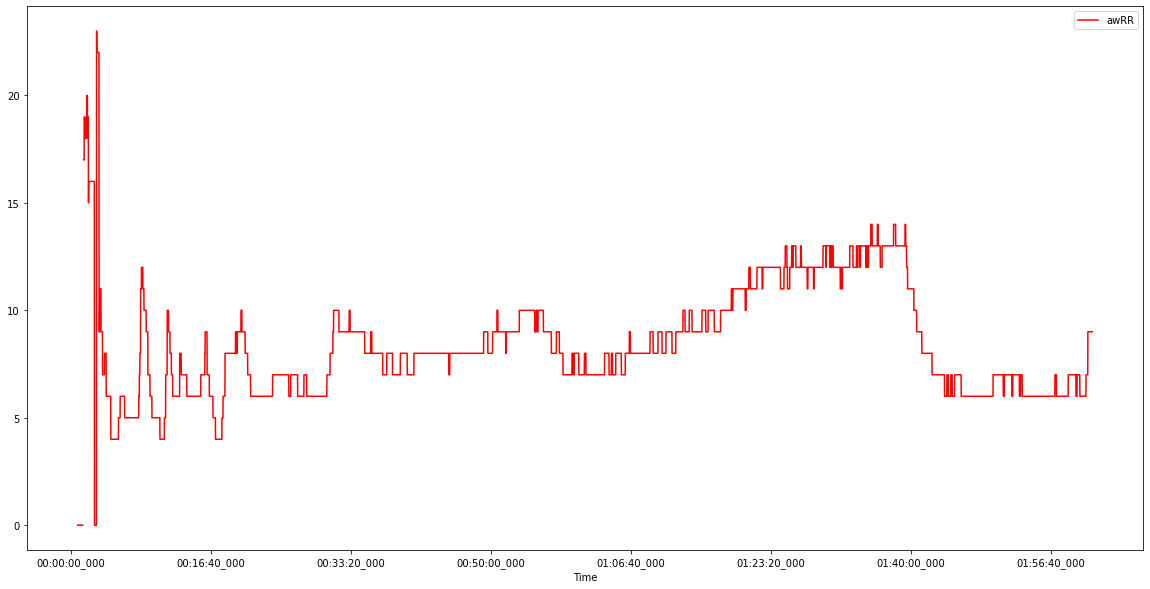

NBP (Sys)


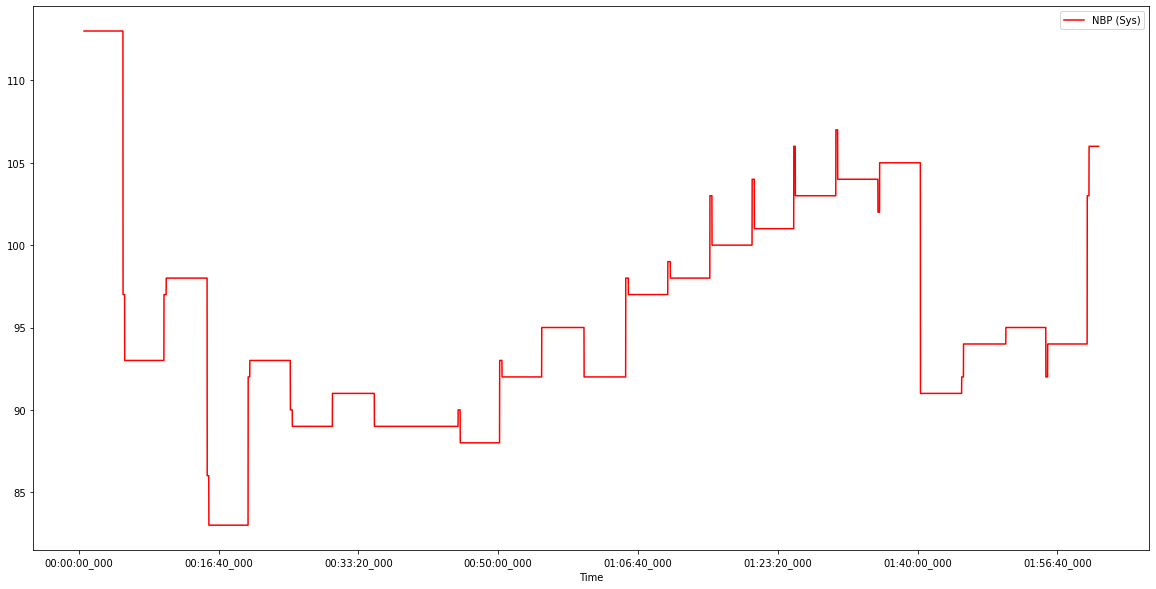

NBP (Dia)


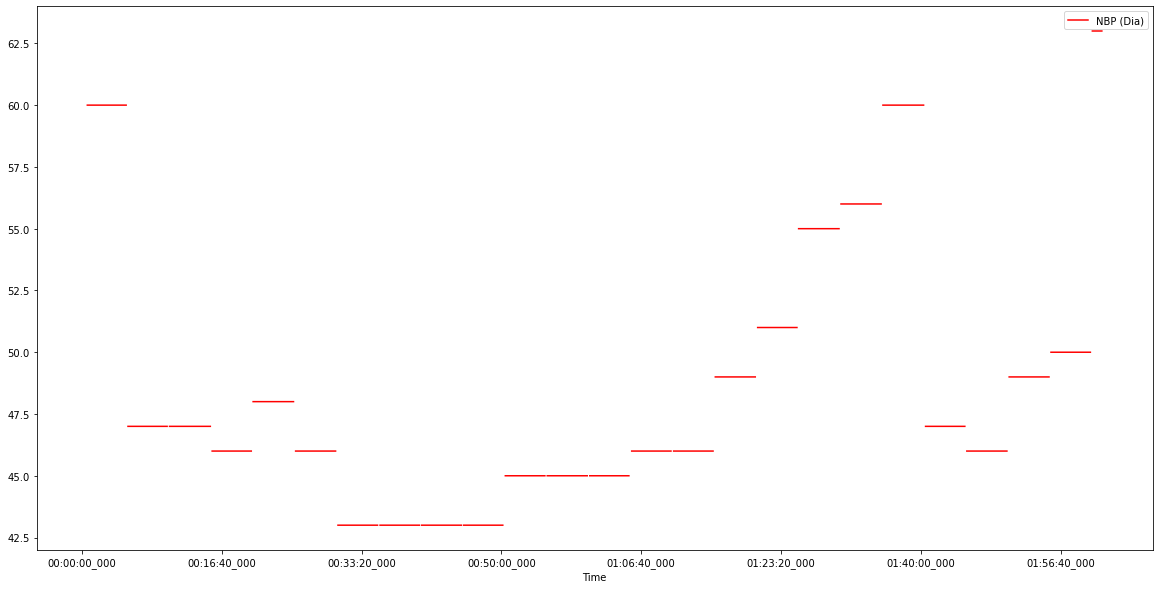

NBP (Mean)


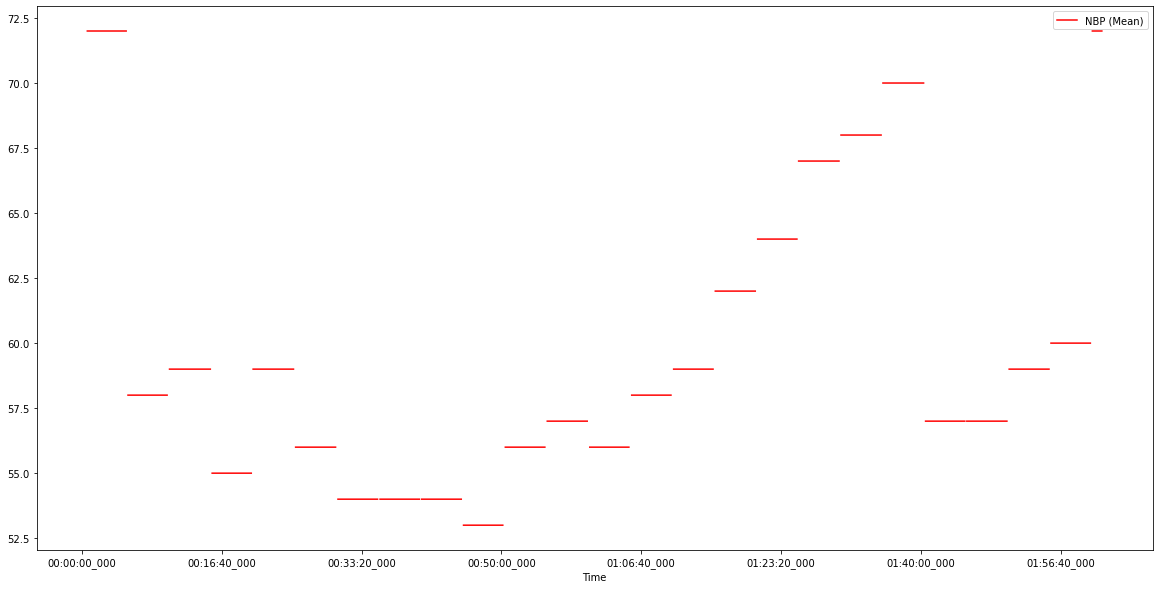

etSEV


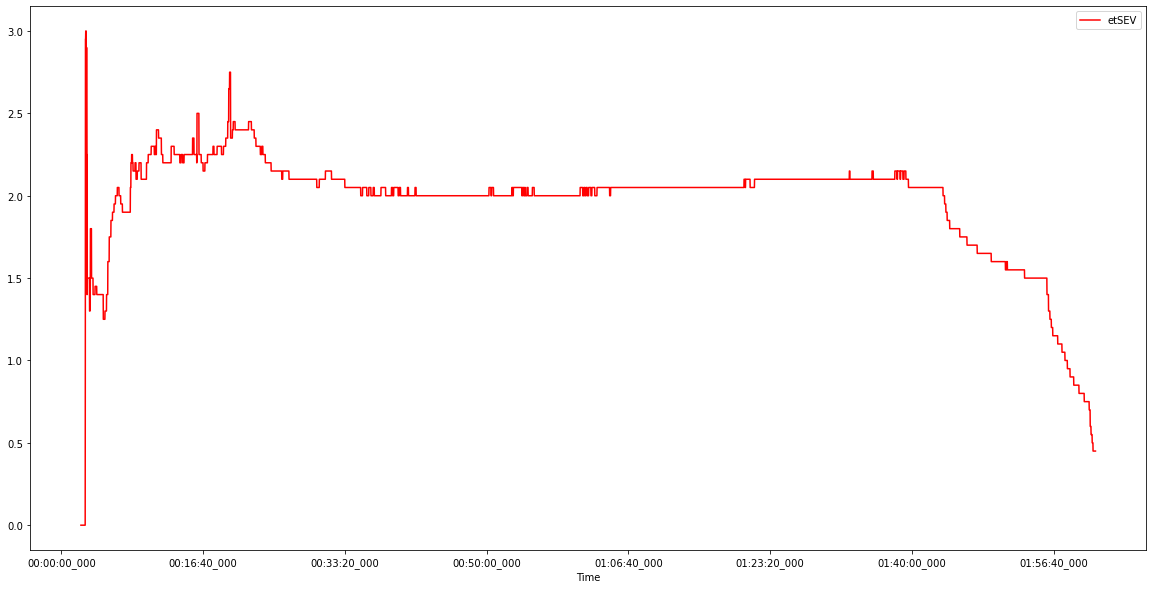

inSEV


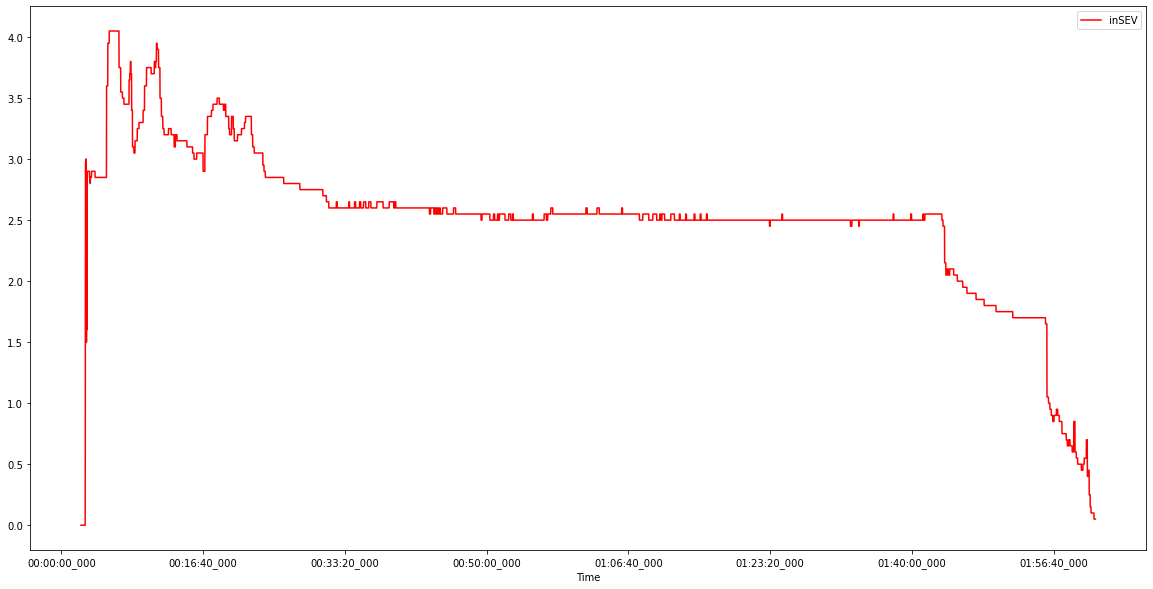

etN2O


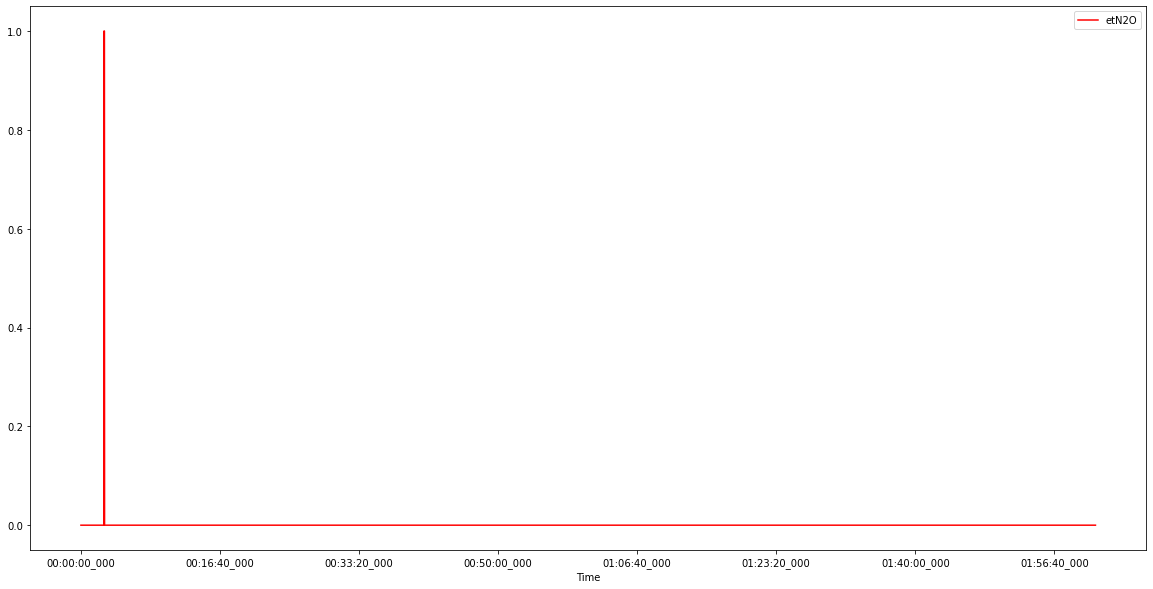

inN2O


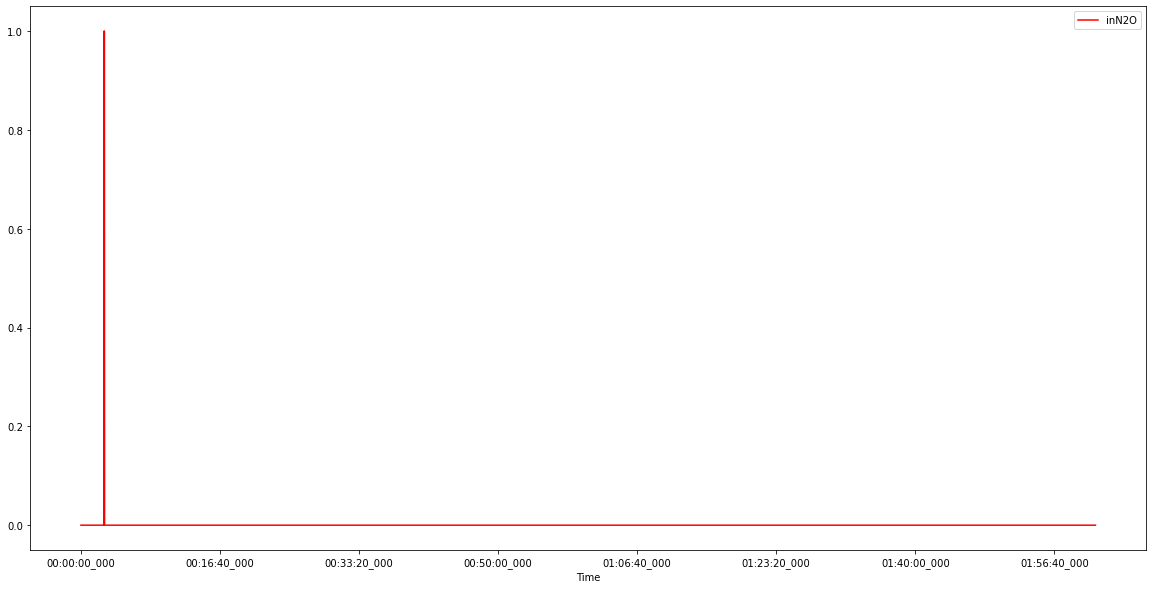

MAC


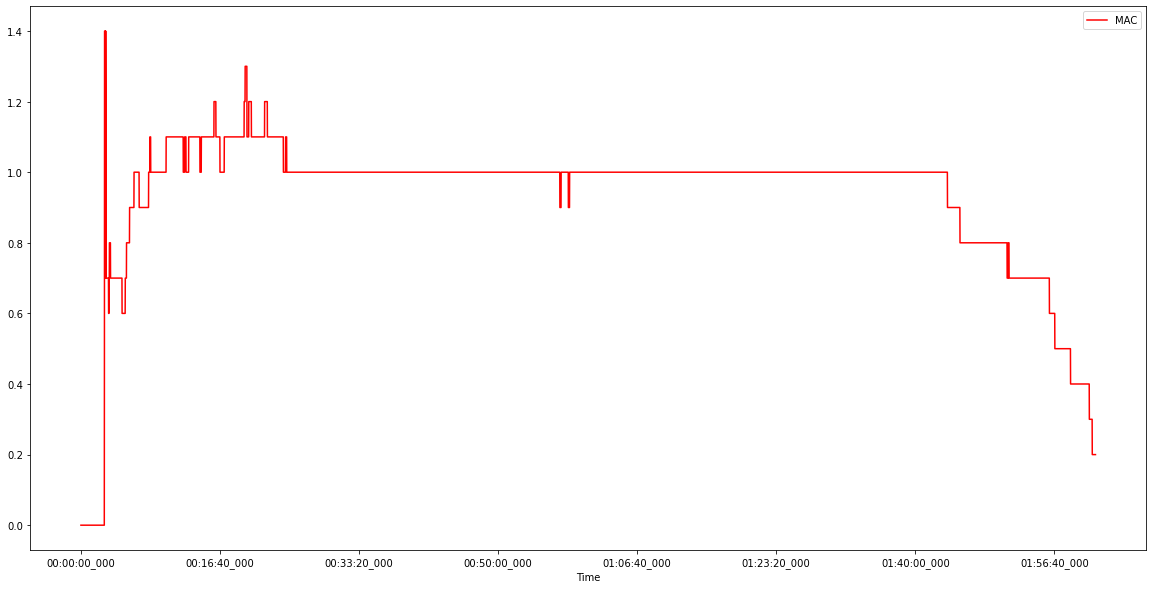

etO2


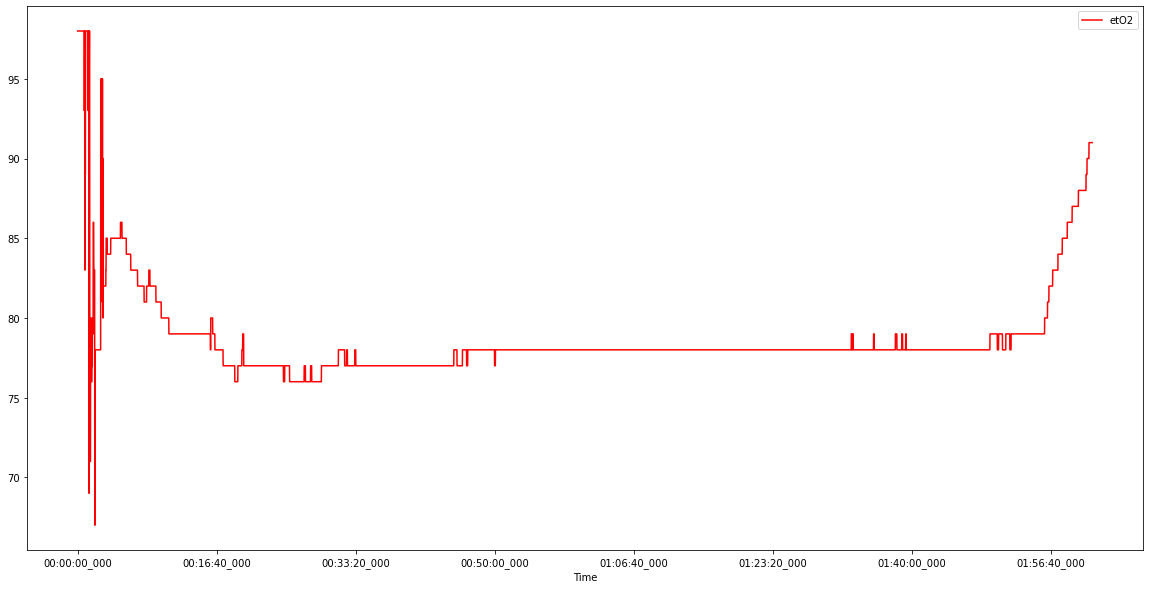

inO2


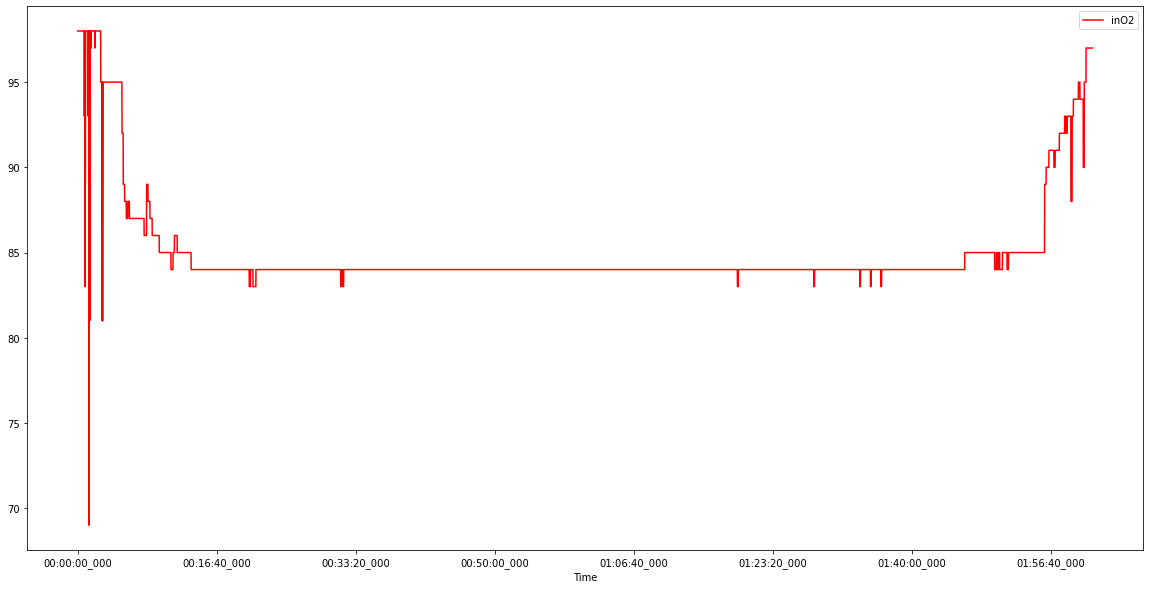

Tidal Volume


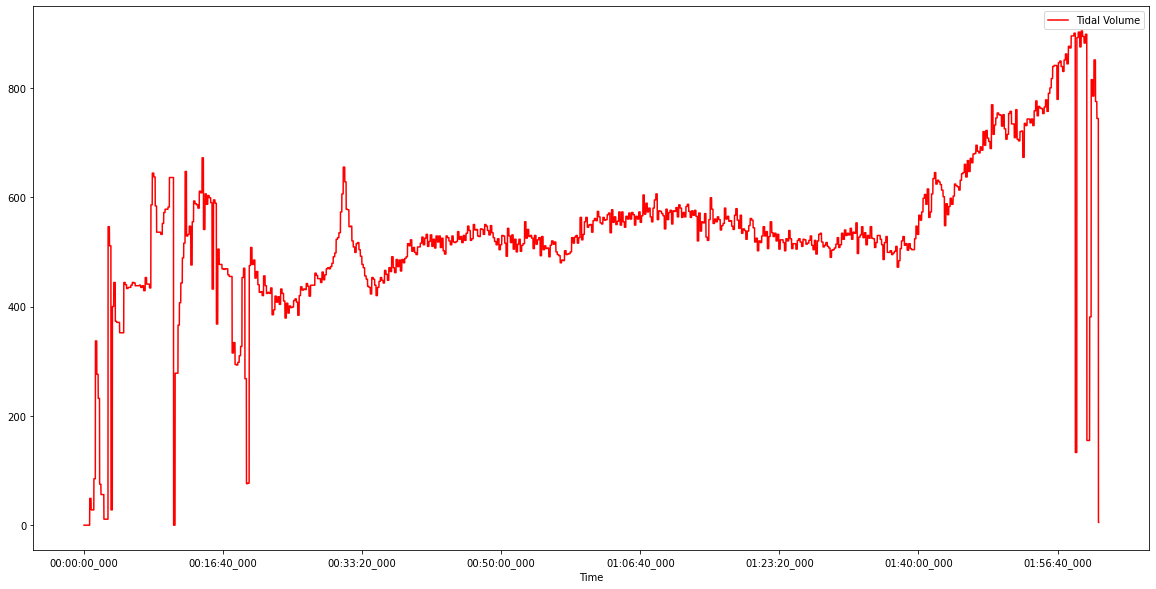

Minute Volume


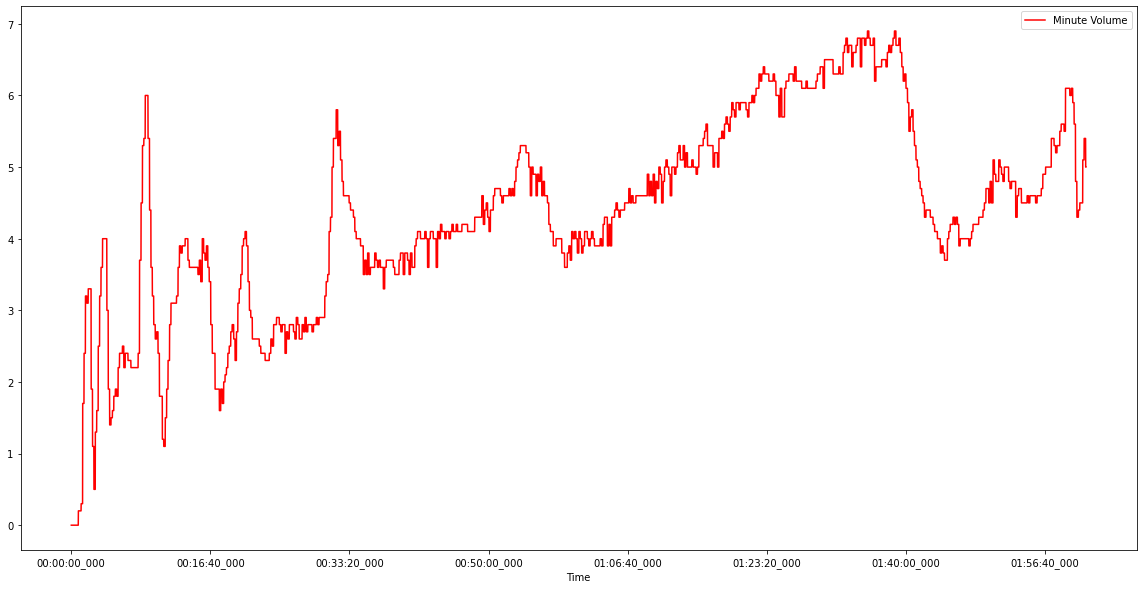

RR


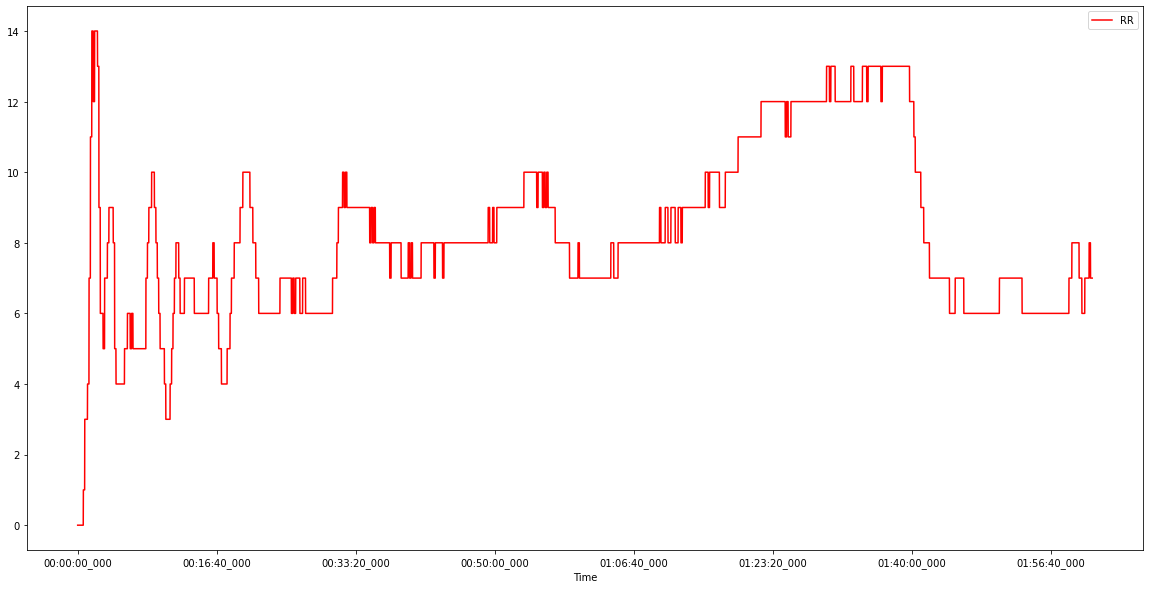

Num Patient Alarms


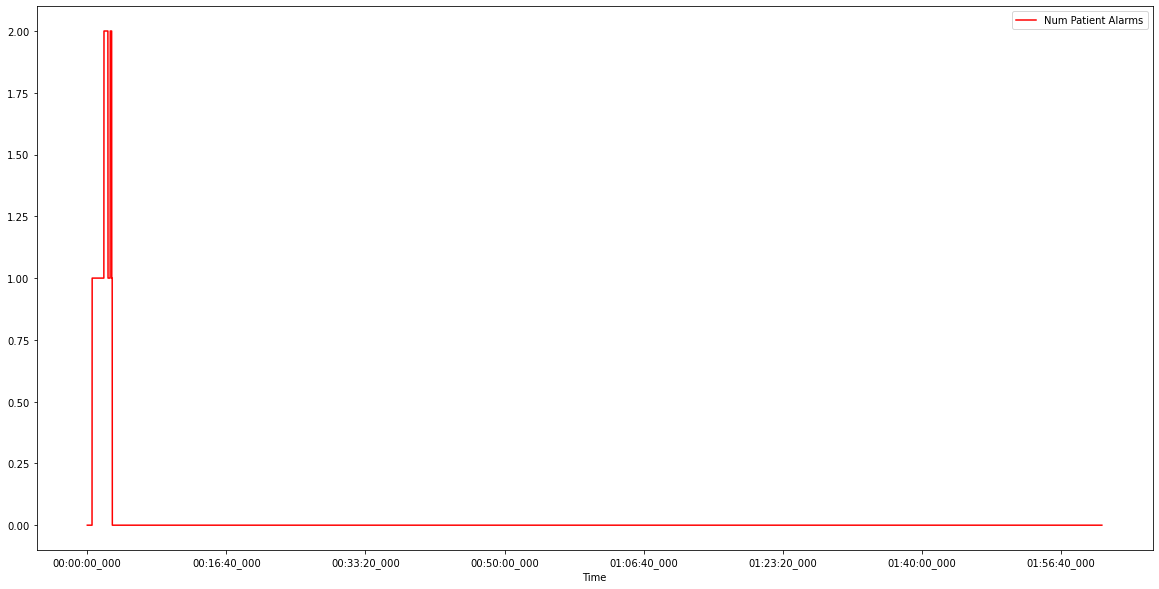

Num Technical Alarms


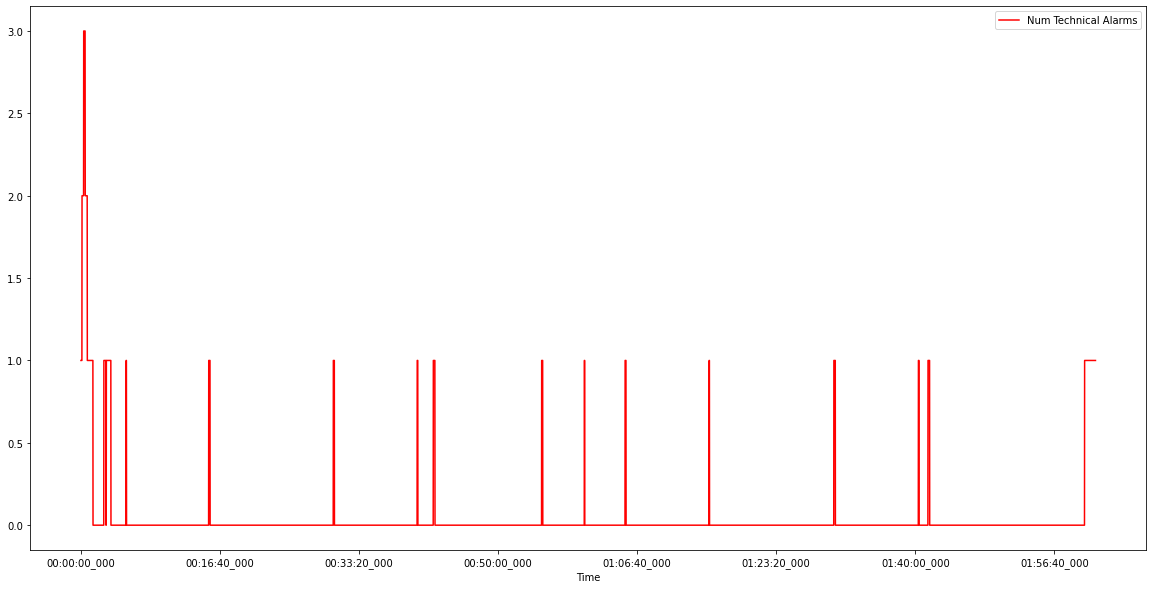

In [19]:
columns = list(df_removed_allnan)
columns.remove('Time')
columns.remove('RelativeTimeMilliseconds')
columns.remove('Clock')
columns.remove('Alarms...')

print(columns)
for i in columns:
    print(i)
    df_removed_allnan.plot(kind='line',x='Time',y= i ,color='red')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

In [20]:
keepList= ["HR", "Pulse", "SpO2", "Perf", "awRR", "Tidal Volume", "Minute Volume", "RR"]

In [21]:
dropList = list(set(columns).difference(keepList))
print(dropList)

for item in dropList:
    df_removed_allnan.drop(str(item), inplace=True, axis=1)


print(df_removed_allnan.keys())

['Num Patient Alarms', 'MAC', 'inO2', 'NBP (Sys)', 'NBP (Dia)', 'inN2O', 'etCO2', 'imCO2', 'Num Technical Alarms', 'NBP (Mean)', 'etO2', 'etSEV', 'inSEV', 'etN2O']
Index(['Time', 'RelativeTimeMilliseconds', 'Clock', 'HR', 'Pulse', 'SpO2',
       'Perf', 'awRR', 'Tidal Volume', 'Minute Volume', 'RR', 'Alarms...'],
      dtype='object')


In [23]:
df_removed_allnan.drop("Alarms...", inplace=True, axis=1)
df_removed_allnan.drop("RelativeTimeMilliseconds", inplace=True, axis=1)

In [24]:
df_removed_allnan.keys()

Index(['Time', 'Clock', 'HR', 'Pulse', 'SpO2', 'Perf', 'awRR', 'Tidal Volume',
       'Minute Volume', 'RR'],
      dtype='object')

In [25]:
df_removed_allnan.isnull().sum()

Time              0
Clock             0
HR               80
Pulse             7
SpO2              7
Perf              7
awRR             51
Tidal Volume      0
Minute Volume     0
RR                0
dtype: int64

In [26]:
df_removed_allnan['Time'] = df_removed_allnan['Time'].str.replace('_000', '')

In [29]:
df_mainfeatures = df_removed_allnan.copy()

In [30]:
df_mainfeatures.head()

,Time,Clock,HR,Pulse,SpO2,Perf,awRR,Tidal Volume,Minute Volume,RR
0,00:00:00,17:33,55.0,55.0,100.0,0.4,NaN,0,0.0,0
1,00:00:01,17:33,55.0,55.0,100.0,0.4,NaN,0,0.0,0
2,00:00:02,17:33,55.0,54.0,100.0,0.4,NaN,0,0.0,0
3,00:00:03,17:33,55.0,54.0,100.0,0.3,NaN,0,0.0,0
4,00:00:04,17:33,55.0,49.0,100.0,0.3,NaN,0,0.0,0


In [31]:
Time_series = df_mainfeatures["Time"]
type(Time_series)

pandas.core.series.Series

In [34]:
timestamp_pd = pd.to_timedelta(df_mainfeatures['Time'])
timestamp_pd = timestamp_pd.to_numpy()
print(timestamp_pd)

[            0    1000000000    2000000000 ... 7293000000000 7294000000000
 7295000000000]


In [37]:
RR_pd = df_mainfeatures["RR"]
RR_pd

0       0
1       0
2       0
3       0
4       0
       ..
7291    7
7292    7
7293    7
7294    7
7295    7
Name: RR, Length: 7296, dtype: int64

In [38]:
RR_pd = RR_pd.to_numpy()

In [39]:
# Fit the model scikit-learn
amp_scale = 20
len_scale = 5 # minute
gpr_kernel_skl = amp_scale * gp.kernels.RBF(length_scale = len_scale)
gpr_model_skl = gp.GaussianProcessRegressor(kernel=gpr_kernel_skl, normalize_y=True)
stime = time.time()
gpr_model_skl.fit(timestamp_pd.reshape(-1, 1), RR_pd)
print("Time for GPR fitting: %.3f (second)" % (time.time() - stime))

Time for GPR fitting: 156.869 (second)
